In [1]:
import proplot as pplt
import numpy as np
import xarray as xr
import dask
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import glob
import dask.array as da
from metpy.units import units
from scipy import stats
from scipy.stats import linregress

In [2]:
# file_path = '/work/mh0033/m301036/LSAT/CMIP6-MPI-M-LR/regrid'
# file_list = glob.glob(file_path+'tas_Amon_MPI-ESM1-2-LR_historical_*.nc')
# file_list = file_list[0:29]
# print(file_list)
# len(file_list)

In [3]:
# import os
# os.listdir('/work/mh0033/m301036/LSAT/CMIP6-MPI-M-LR/regrid')

In [26]:
data_hist_MPI_ESM  = '/work/mh0033/m301036/LSAT/MPI-GE/hist_1850-2005_ens_1-100.tsurf.recon.nc'
ds = xr.open_mfdataset(data_hist_MPI_ESM)
ds
# #data_hist_CanESM5 = '/pool/data/CMIP6/data/CMIP/CCCma/CanESM5/historical/tas_*.nc'
# #data_hist_GFDL    = '/pool/data/CMIP6/data/ScenarioMIP/MPI-M/MPI-ESM1-2-LR/ssp245/r1i1p1f1/Amon/tas/gn/v20190710/tas_*.nc'
# #data_ssp370 = '/pool/data/CMIP6/data/ScenarioMIP/MPI-M/MPI-ESM1-2-LR/ssp370/r1i1p1f1/Amon/tas/gn/v20190710/tas_*.nc'
# #data_ssp585 = '/pool/data/CMIP6/data/ScenarioMIP/MPI-M/MPI-ESM1-2-LR/ssp585/r1i1p1f1/Amon/tas/gn/v20190710/tas_*.nc'
# import glob
# myfiles = glob.glob(data_hist_MPI_ESM)
# file_list = sorted(myfiles)
# file_list

<xarray.Dataset>
Dimensions:  (time: 1872, lon: 192, lat: 96, ens: 100)
Coordinates:
  * time     (time) datetime64[ns] 1850-01-31T23:52:00 ... 2005-12-31T23:52:00
  * lon      (lon) float32 0.0 1.875 3.75 5.625 7.5 ... 352.5 354.4 356.2 358.1
  * lat      (lat) float32 88.57 86.72 84.86 83.0 ... -83.0 -84.86 -86.72 -88.57
Dimensions without coordinates: ens
Data variables:
    tsurf    (time, ens, lat, lon) float32 dask.array<chunksize=(1872, 100, 96, 192), meta=np.ndarray>
Attributes:
    CDI:                       Climate Data Interface version 2.0.6 (https://...
    Conventions:               CF-1.6
    source:                    ECHAM6
    institution:               Max-Planck-Institute for Meteorology
    history:                   Thu Jun 01 11:05:15 2023: cdo -r copy /work/mh...
    NCO:                       4.6.7
    nco_openmp_thread_number:  1
    CDO:                       Climate Data Operators version 2.0.6 (https://...

In [7]:
#Perfrom land sea mask
land_sea_mask=xr.open_dataset('/work/mh0033/m301036/LSAT/CMIP6-MPI-M-LR/GR15_lsm_regrid.nc')
# land_sea_mask.coords
display(land_sea_mask)
# land_sea_mask.coords

<xarray.Dataset>
Dimensions:  (time: 1, lon: 180, lat: 90)
Coordinates:
  * time     (time) float64 201.0
  * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * lat      (lat) float64 -89.0 -87.0 -85.0 -83.0 -81.0 ... 83.0 85.0 87.0 89.0
Data variables:
    var1     (time, lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 2.0.6 (https://mpimet.mpg.de...
    Conventions:  CF-1.0
    history:      Sun May 14 21:24:57 2023: cdo remapbil,r180x90 /pool/data/M...
    CDO:          Climate Data Operators version 2.0.6 (https://mpimet.mpg.de...

In [8]:
mask_data = land_sea_mask['var1']
mask_data
# Align the time coordinates between the mask dataset and the original dataset
time_values = pd.to_datetime(mask_data['time'].values, format='mixed', dayfirst=True)
mask_data['time'] = time_values

# Align the time coordinates between the mask dataset and the original dataset
mask_data = mask_data.reindex(time=ds['time'], method='nearest')

# Apply the land-sea mask to the original dataset
masked_tas = ds.where(mask_data == 1, drop=False)

# # Broadcast the mask to match the shape of the original dataset's time dimension
# broadcasted_mask = xr.broadcast(mask_data, ds['time'])[0]

# # Apply the land-sea mask to the original dataset
# masked_tas = xr.where(broadcasted_mask == 1, ds, np.nan).fillna(np.nan)

# Print the resulting masked dataset
masked_tas

<xarray.Dataset>
Dimensions:    (run: 30, time: 1980, bnds: 2, lat: 90, lon: 180)
Coordinates:
  * time       (time) datetime64[ns] 1850-01-16T12:00:00 ... 2014-12-16T12:00:00
  * lon        (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * lat        (lat) float64 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
    height     float64 2.0
  * run        (run) int64 1 2 3 4 5 6 7 8 9 10 ... 22 23 24 25 26 27 28 29 30
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (run, time, bnds, lat, lon) datetime64[ns] dask.array<chunksize=(1, 1980, 2, 90, 180), meta=np.ndarray>
    tas        (run, time, lat, lon) float32 dask.array<chunksize=(1, 1980, 90, 180), meta=np.ndarray>
Attributes: (12/49)
    CDI:                    Climate Data Interface version 2.0.6 (https://mpi...
    source:                 MPI-ESM1.2-LR (2017): \naerosol: none, prescribed...
    institution:            Max Planck Institute for Meteorology, Hamburg 201...
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    ...                     ...
    variable_id:            tas
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by MPI-M is licensed un...
    cmor_version:           3.5.0
    tracking_id:            hdl:21.14100/6b679cba-17b8-45eb-90dc-23d170c1998c
    CDO:                    Climate Data Operators version 2.0.6 (https://mpi...

In [32]:
tas = ds['tsurf'].loc['1900-01-01':'2005-12-31',:,::-1,:]
tas

<xarray.DataArray 'tsurf' (time: 1272, ens: 100, lat: 96, lon: 192)>
dask.array<getitem, shape=(1272, 100, 96, 192), dtype=float32, chunksize=(1272, 100, 96, 192), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1900-01-31T23:52:00 ... 2005-12-31T23:52:00
  * lon      (lon) float32 0.0 1.875 3.75 5.625 7.5 ... 352.5 354.4 356.2 358.1
  * lat      (lat) float32 -88.57 -86.72 -84.86 -83.0 ... 83.0 84.86 86.72 88.57
Dimensions without coordinates: ens
Attributes:
    long_name:         surface temperature
    units:             K
    code:              169
    table:             128
    CDI_grid_type:     gaussian
    CDI_grid_num_LPE:  48

In [33]:
tas = tas - 273.15
tas_climatology = tas.groupby('time.month').mean(dim='time')
tas_ano = tas - tas.mean()
tas_ano
# lat = tas_ano['lat']
# lon = tas_ano['lon']

/home/m/m301036/.conda/envs/mykernel/lib/python3.9/site-packages/xarray/core/indexing.py:1440: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/home/m/m301036/.conda/envs/mykernel/lib/python3.9/site-packages/xarray/core/indexing.py:1440: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[k

<xarray.DataArray 'tsurf' (time: 1272, ens: 100, lat: 96, lon: 192)>
dask.array<sub, shape=(1272, 100, 96, 192), dtype=float32, chunksize=(1272, 100, 96, 192), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1900-01-31T23:52:00 ... 2005-12-31T23:52:00
  * lon      (lon) float32 0.0 1.875 3.75 5.625 7.5 ... 352.5 354.4 356.2 358.1
  * lat      (lat) float32 -88.57 -86.72 -84.86 -83.0 ... 83.0 84.86 86.72 88.57
Dimensions without coordinates: ens

In [34]:
#Separate data into monthly and output as new nc file
time_data = tas_ano['time']
time_index = pd.to_datetime(time_data.values)
time_index

DatetimeIndex(['1900-01-31 23:52:00', '1900-02-28 23:52:00',
               '1900-03-31 23:52:00', '1900-04-30 23:52:00',
               '1900-05-31 23:52:00', '1900-06-30 23:52:00',
               '1900-07-31 23:52:00', '1900-08-31 23:52:00',
               '1900-09-30 23:52:00', '1900-10-31 23:52:00',
               ...
               '2005-03-31 23:52:00', '2005-04-30 23:52:00',
               '2005-05-31 23:52:00', '2005-06-30 23:52:00',
               '2005-07-31 23:52:00', '2005-08-31 23:52:00',
               '2005-09-30 23:52:00', '2005-10-31 23:52:00',
               '2005-11-30 23:52:00', '2005-12-31 23:52:00'],
              dtype='datetime64[ns]', length=1272, freq=None)

In [11]:
# for month in time_index.month.unique():
#     month_data = tas_ano.sel(time=time_index.month==month)
#     output_file_path= f"/work/mh0033/m301036/LSAT/Merged-CMIP6/tas_hist_{month}.nc"
#     month_data.to_netcdf(output_file_path)

In [36]:
weights = np.cos(np.deg2rad(tas.lat))*xr.ones_like(tas['lon'])

In [48]:
#calculate the annual mean of the SAT
# weights = np.cos(np.deg2rad(tas_ano.lat))
# weights.name = "weights"
# weights

tas_ano_weighted = tas_ano.sel(lat=slice(0,90)).weighted(weights)
# display(tas_ano_weighted)
tas_ano_weighted_mean = tas_ano_weighted.mean(dim=['lat','lon'])
tas_ano_weighted_mean

<xarray.DataArray 'tsurf' (time: 1272, ens: 100)>
dask.array<truediv, shape=(1272, 100), dtype=float32, chunksize=(1272, 100), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1900-01-31T23:52:00 ... 2005-12-31T23:52:00
Dimensions without coordinates: ens

In [49]:
tas_ano_annual = tas_ano_weighted_mean.groupby('time.year').mean('time')
tas_ano_annual
# display(tas_ano_annual.min().values)
# tas_ano_annual.max().values

<xarray.DataArray 'tsurf' (year: 106, ens: 100)>
dask.array<stack, shape=(106, 100), dtype=float32, chunksize=(1, 100), chunktype=numpy.ndarray>
Coordinates:
  * year     (year) int64 1900 1901 1902 1903 1904 ... 2001 2002 2003 2004 2005
Dimensions without coordinates: ens

In [50]:
seasons = ['JJA', 'DJF']
season_means = {}

for season in seasons:
    if season == 'JJA':
        months = [6,7,8]
    elif season == 'DJF':
        months =[12,1,2]
    
    season_months = tas_ano.sel(time=tas.time.dt.month.isin(months),lat=slice(0,90))
    
    # Calculate the seasonal mean SAT anomalies
    season_mean_anomalies = (season_months * weights).mean(dim=['lat', 'lon']) / weights.mean(dim=['lat', 'lon'])
    
    # Store the seasonal mean in the dictionary
    season_means[season] = season_mean_anomalies

# Access the multiyear JJA mean SAT anomalies
    
JJA_tas = season_means['JJA']
DJF_tas = season_means['DJF']

JJA_tas

/home/m/m301036/.conda/envs/mykernel/lib/python3.9/site-packages/xarray/core/indexing.py:1440: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/home/m/m301036/.conda/envs/mykernel/lib/python3.9/site-packages/xarray/core/indexing.py:1440: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[k

<xarray.DataArray (time: 318, ens: 100)>
dask.array<truediv, shape=(318, 100), dtype=float32, chunksize=(318, 100), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1900-06-30T23:52:00 ... 2005-08-31T23:52:00
Dimensions without coordinates: ens

In [51]:
DJF_tas_mean = DJF_tas.groupby('time.year').mean(dim='time')
DJF_tas_mean

<xarray.DataArray (year: 106, ens: 100)>
dask.array<stack, shape=(106, 100), dtype=float32, chunksize=(1, 100), chunktype=numpy.ndarray>
Coordinates:
  * year     (year) int64 1900 1901 1902 1903 1904 ... 2001 2002 2003 2004 2005
Dimensions without coordinates: ens

In [52]:
JJA_tas_mean = JJA_tas.groupby('time.year').mean(dim='time')
# JJA_tas_mean[0,:].values
JJA_tas_mean

<xarray.DataArray (year: 106, ens: 100)>
dask.array<stack, shape=(106, 100), dtype=float32, chunksize=(1, 100), chunktype=numpy.ndarray>
Coordinates:
  * year     (year) int64 1900 1901 1902 1903 1904 ... 2001 2002 2003 2004 2005
Dimensions without coordinates: ens

In [53]:
window_size =15
rolled = tas_ano_annual.rolling(year=15, center=True).construct("window_size")
rolled[0,:,:]

<xarray.DataArray 'tsurf' (ens: 100, window_size: 15)>
dask.array<getitem, shape=(100, 15), dtype=float32, chunksize=(100, 15), chunktype=numpy.ndarray>
Coordinates:
    year     int64 1900
Dimensions without coordinates: ens, window_size

In [54]:
#mask 
nyears = 106
windows = 92
k=0
mask = np.zeros((windows, nyears))
for i in range(windows):
    mask[i,k:k+15]=1
    k=k+1

In [55]:
mask[0],mask[1]

windows = xr.DataArray(np.arange(0,92,1), dims='windows')
year = xr.DataArray(np.arange(1900, 2006,1), dims='year')
new_dims = {'windows': windows, 'year': year}
mask = xr.DataArray(mask,dims=('windows','year'), coords=new_dims)
type(mask)
display(mask)

<xarray.DataArray (windows: 92, year: 106)>
array([[1., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 1., 0.],
       [0., 0., 0., ..., 1., 1., 1.]])
Coordinates:
  * windows  (windows) int64 0 1 2 3 4 5 6 7 8 9 ... 83 84 85 86 87 88 89 90 91
  * year     (year) int64 1900 1901 1902 1903 1904 ... 2001 2002 2003 2004 2005

In [56]:
tas_ano_annual= xr.DataArray(tas_ano_annual)
display(tas_ano_annual)
# tas_ano_annual_reshaped = tas_ano_annual.broadcast_like(mask)
masked_annual_tas = mask*tas_ano_annual
masked_annual_tas

<xarray.DataArray 'tsurf' (year: 106, ens: 100)>
dask.array<stack, shape=(106, 100), dtype=float32, chunksize=(1, 100), chunktype=numpy.ndarray>
Coordinates:
  * year     (year) int64 1900 1901 1902 1903 1904 ... 2001 2002 2003 2004 2005
Dimensions without coordinates: ens

<xarray.DataArray (windows: 92, year: 106, ens: 100)>
dask.array<multiply, shape=(92, 106, 100), dtype=float64, chunksize=(92, 1, 100), chunktype=numpy.ndarray>
Coordinates:
  * windows  (windows) int64 0 1 2 3 4 5 6 7 8 9 ... 83 84 85 86 87 88 89 90 91
  * year     (year) int64 1900 1901 1902 1903 1904 ... 2001 2002 2003 2004 2005
Dimensions without coordinates: ens

In [57]:
#the data should be the masked_annual_tas
#  dim is the selected run
#  trend is the returning running 15 year trend with the dimension size '101'
def polyfit_run(data):
    trend = np.zeros(92)
    for i in range(92):
        trend[i] = np.polyfit(range(15), data[i,:][data[i,:] != 0], deg=1)[0]
    return trend

In [59]:
window_size = 15

num_runs=100
num_points  = 106
num_windows = num_points - window_size + 1 

trend = np.zeros((num_runs,num_windows))

for irun in range(100):
    trend[irun,:]=polyfit_run(masked_annual_tas.isel(ens=irun).values)

In [61]:
trend

array([[-0.01924616, -0.01024586, -0.00330178, ...,  0.02633363,
         0.03652495,  0.04520928],
       [ 0.01384595,  0.01418012,  0.02079657, ...,  0.02153626,
         0.02619912,  0.03861973],
       [-0.02644818, -0.0160331 , -0.00059155, ...,  0.02434453,
         0.02537855,  0.0300789 ],
       ...,
       [-0.00361604,  0.00558578,  0.00610874, ...,  0.02858509,
         0.02435453,  0.02424527],
       [-0.01387788, -0.01582905, -0.01382813, ...,  0.03826202,
         0.03862464,  0.03963808],
       [-0.0060893 , -0.00522688, -0.00195677, ...,  0.03535585,
         0.03664421,  0.03232063]])

In [79]:
tas_ano_JJA= xr.DataArray(JJA_tas_mean)
display(tas_ano_JJA)
# tas_ano_annual_reshaped = tas_ano_annual.broadcast_like(mask)
masked_JJA_tas = mask*tas_ano_JJA
masked_JJA_tas

<xarray.DataArray (year: 106, ens: 100)>
dask.array<stack, shape=(106, 100), dtype=float32, chunksize=(1, 100), chunktype=numpy.ndarray>
Coordinates:
  * year     (year) int64 1900 1901 1902 1903 1904 ... 2001 2002 2003 2004 2005
Dimensions without coordinates: ens

<xarray.DataArray (windows: 92, year: 106, ens: 100)>
dask.array<multiply, shape=(92, 106, 100), dtype=float64, chunksize=(92, 1, 100), chunktype=numpy.ndarray>
Coordinates:
  * windows  (windows) int64 0 1 2 3 4 5 6 7 8 9 ... 83 84 85 86 87 88 89 90 91
  * year     (year) int64 1900 1901 1902 1903 1904 ... 2001 2002 2003 2004 2005
Dimensions without coordinates: ens

In [80]:
tas_ano_DJF= xr.DataArray(DJF_tas_mean)
display(tas_ano_DJF)
# tas_ano_annual_reshaped = tas_ano_annual.broadcast_like(mask)
masked_DJF_tas = mask*tas_ano_DJF
masked_DJF_tas

<xarray.DataArray (year: 106, ens: 100)>
dask.array<stack, shape=(106, 100), dtype=float32, chunksize=(1, 100), chunktype=numpy.ndarray>
Coordinates:
  * year     (year) int64 1900 1901 1902 1903 1904 ... 2001 2002 2003 2004 2005
Dimensions without coordinates: ens

<xarray.DataArray (windows: 92, year: 106, ens: 100)>
dask.array<multiply, shape=(92, 106, 100), dtype=float64, chunksize=(92, 1, 100), chunktype=numpy.ndarray>
Coordinates:
  * windows  (windows) int64 0 1 2 3 4 5 6 7 8 9 ... 83 84 85 86 87 88 89 90 91
  * year     (year) int64 1900 1901 1902 1903 1904 ... 2001 2002 2003 2004 2005
Dimensions without coordinates: ens

In [85]:
trend_JJA = np.zeros((num_runs,num_windows))

for irun in range(100):
    trend_JJA[irun,:]=polyfit_run(masked_JJA_tas.isel(ens=irun).values)

In [86]:
trend_DJF = np.zeros((num_runs,num_windows))

for irun in range(100):
    trend_DJF[irun,:]=polyfit_run(masked_DJF_tas.isel(ens=irun).values)

In [28]:
# polyfit_run_window(masked_annual_tas.isel(run=0).values)

In [29]:
# annual_trend = xr.apply_ufunc(polyfit_run,masked_annual_tas,input_core_dims=[['windows','year']], output_core_dims=[['windows']],
#                               vectorize=True, dask='parallelized', dask_gufunc_kwargs=dict(allow_rechunk=True))

In [30]:
# tas_run1 = tas_ano_annual.isel(run=0).values
# tas_run1.shape, tas_run1

In [31]:
# def crop(arr, i, j):
#     return arr[i:j]

# crop_vec = np.vectorize(crop)

# istart = np.arange(0,101,1).astype(int)
# iend = np.arange(14,115,1).astype(int)
# print(istart.size, istart)
# print(iend.size, iend)

# tas_run1_vec = tas_run1.repeat(101).reshape((101,115))
# print(tas_run1_vec.shape)
# #np.arange(0,102,1).shape, np.arange(14,116,1).shape, tas_run1_vec.size
# print([tas_run1]*101) 
# #crop_vec([tas_run1]*101, istart, iend)

In [32]:
# tas_run1 = tas_ano_annual.isel(run=0)
# tas_run1 = tas_run1.data

In [33]:
# # Define the window size (15 years)
# window_size = 15

# num_years = tas_run1.shape
# num_runs=30
# # Calculate the number of data points in the window
# num_points  = 115
# num_windows = num_points - window_size + 1 

# trend = np.zeros((num_runs,num_windows))
# for j in range(num_runs):
#     print('run ', j)
#     for i in range(num_windows):
#         tas_run = tas_ano_annual.isel(run=j).values
#         run_window_data = tas_run[i:i+window_size]
#         time = np.arange(len(run_window_data))
        
#         print(run_window_data)
#         print(time)
#         trend[j,i] = np.polyfit(time, run_window_data, 1)[0]

# print(trend)
# print(len(trend))

In [34]:
#Calculate the 15yr running trend time series
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import signal
from sklearn.linear_model import LinearRegression

In [87]:
# tas_JJA_3dim = np.lib.stride_tricks.sliding_window_view(JJA_tas_mean,(1, window_size))

# trend_JJA = signal.detrend(tas_JJA_3dim, axis=1)
# slope_JJA = trend_JJA[:,:,-1]
# slope_JJA

In [36]:
# tas_DJF_3dim = np.lib.stride_tricks.sliding_window_view(DJF_tas_mean,(1, window_size))
# print(tas_DJF_3dim.shape)
# trend_DJF = signal.detrend(tas_DJF_3dim, axis=1)
# slope_DJF = trend_DJF[:,:,-1]
# slope_DJF

In [88]:
#output 30 run annual mean SAT
# tas_ano_annual_np = tas_ano_annual['tas'].values
x = np.arange(1906,1998,1)
num_time_series = tas_ano_annual.shape[0]

#calculate the ensemble mean of the MPI-ESM-LR 
tas_annual_mean = tas_ano_annual.mean('ens')
# tas_annual_mean.values

In [38]:
# print(min(tas_annual_mean))
# print(max(tas_annual_mean))

In [89]:
year = xr.DataArray(np.arange(1906,1998,1),dims='year')
print(len(year))
trend_mean = trend.mean((0))
trend_JJA_mean = trend_JJA.mean((0))
trend_DJF_mean = trend_DJF.mean((0))

trend_DJF_mean.shape
trend_mean = xr.DataArray(trend_mean,dims=('year'), coords={'year': year})
trend_JJA_mean = xr.DataArray(trend_JJA_mean,dims=('year'), coords={'year': year})
trend_DJF_mean = xr.DataArray(trend_DJF_mean,dims=('year'), coords={'year': year})

92


In [90]:
#input trend data
CRUTEMP_annual = np.genfromtxt(fname='/work/mh0033/m301036/josie/LSAT/output_text/CRUTEMP_annual_NH_trend.txt',delimiter='\t', skip_header=1)
CRUTEMP_JJA = np.genfromtxt(fname='/work/mh0033/m301036/josie/LSAT/output_text/CRUTEMP_JJA_NH_trend.txt',delimiter='\t', skip_header=1)
CRUTEMP_DJF = np.genfromtxt(fname='/work/mh0033/m301036/josie/LSAT/output_text/CRUTEMP_DJF_NH_trend.txt',delimiter='\t', skip_header=1)
CRUTEMP_trend_annual = CRUTEMP_annual[0:92,1]
CRUTEMP_trend_JJA = CRUTEMP_JJA[0:92,1]
CRUTEMP_trend_DJF = CRUTEMP_DJF[0:92,1]

In [91]:
GISS_annual = np.genfromtxt(fname='/work/mh0033/m301036/josie/LSAT/output_text/GISS_annual_NH_trend.txt',delimiter='\t', skip_header=1)
GISS_JJA = np.genfromtxt(fname='/work/mh0033/m301036/josie/LSAT/output_text/GISS_JJA_NH_trend.txt',delimiter='\t', skip_header=1)
GISS_DJF = np.genfromtxt(fname='/work/mh0033/m301036/josie/LSAT/output_text/GISS_DJF_NH_trend.txt',delimiter='\t', skip_header=1)
GISS_trend_annual = GISS_annual[0:92,1]
GISS_trend_JJA = GISS_JJA[0:92,1]
GISS_trend_DJF = GISS_DJF[0:92,1]

In [92]:
MLOST_annual = np.genfromtxt(fname='/work/mh0033/m301036/josie/LSAT/output_text/MLOST_annual_NH_trend.txt',delimiter='\t', skip_header=1)
MLOST_JJA = np.genfromtxt(fname='/work/mh0033/m301036/josie/LSAT/output_text/MLOST_JJA_NH_trend.txt',delimiter='\t', skip_header=1)
MLOST_DJF = np.genfromtxt(fname='/work/mh0033/m301036/josie/LSAT/output_text/MLOST_DJF_NH_trend.txt',delimiter='\t', skip_header=1)
MLOST_trend_annual = MLOST_annual[0:92,1]
MLOST_trend_JJA = MLOST_JJA[0:92,1]
MLOST_trend_DJF = MLOST_DJF[0:92,1]

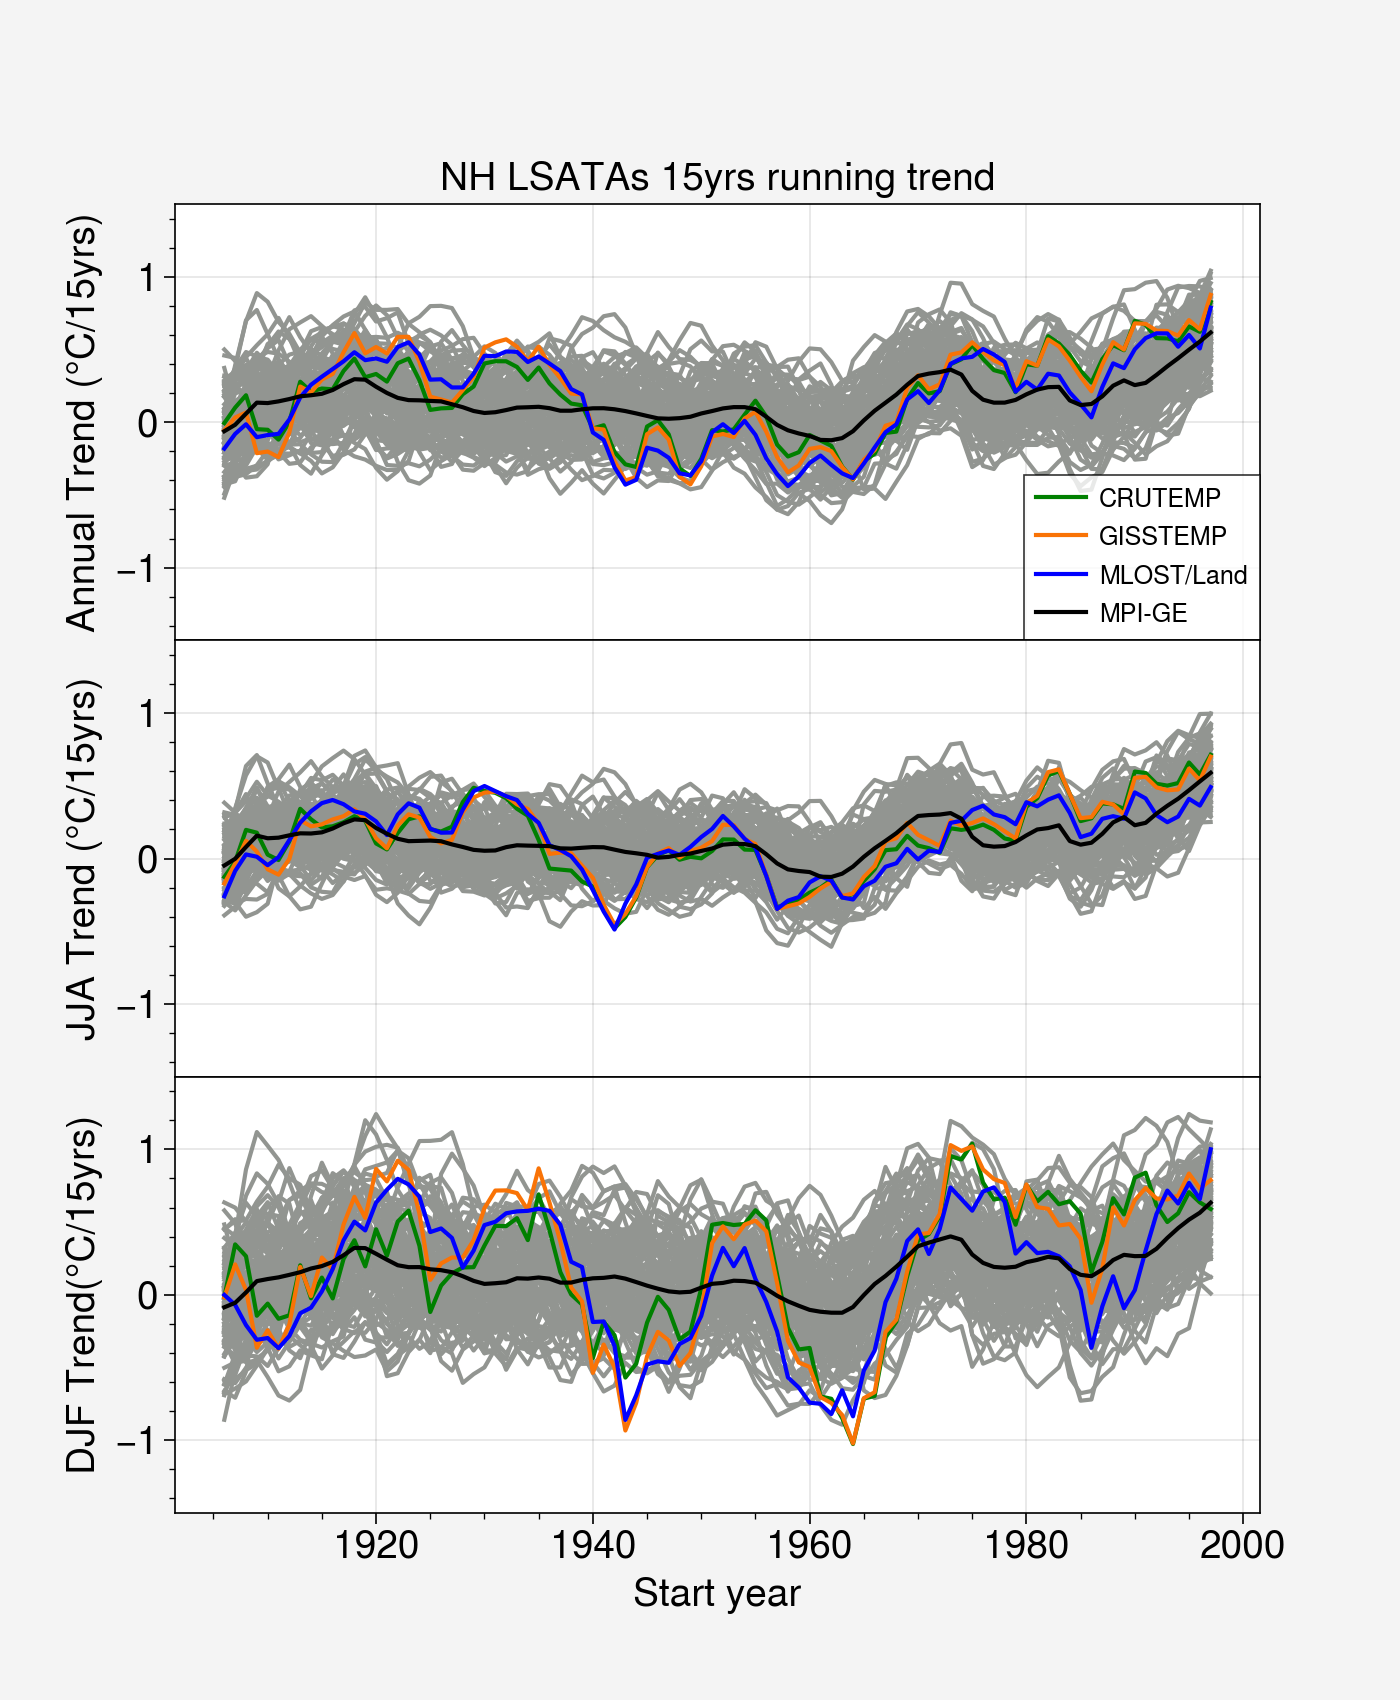

In [96]:
fig,axs = plt.subplots(3,1, figsize=(7,8.5), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0)

num_time_series =100

for i in range(num_time_series):
    axs[0].plot(x, trend[i, :]*15, color='gray')
    
axs[0].plot(x, CRUTEMP_trend_annual*15, color='green', label='CRUTEMP')
axs[0].plot(x, GISS_trend_annual*15, color='orange', label='GISSTEMP')
axs[0].plot(x, MLOST_trend_annual*15, color='blue', label='MLOST/Land')
axs[0].plot(x, trend_mean*15, color='black', label='MPI-GE')
axs[0].set_title('NH LSATAs 15yrs running trend',fontsize=14)
axs[0].set_ylabel('Annual Trend (°C/15yrs)', fontsize=14)
axs[0].set_xlabel('Start year', fontsize=14)
axs[0].set(ylim=(-1.5,1.5))
# axs[0].grid(visible=False, which='major', axis='y')
axs[0].tick_params(axis='x', labelsize=14)
axs[0].tick_params(axis='y', labelsize=14)
axs[0].legend()
# Plot the JJA time series
for i in range(num_time_series):
    axs[1].plot(x, trend_JJA[i, :]*15, color='gray')

axs[1].plot(x, CRUTEMP_trend_JJA*15, color='green')
axs[1].plot(x, GISS_trend_JJA*15, color='orange')
axs[1].plot(x, MLOST_trend_JJA*15, color='blue')
axs[1].plot(x, trend_JJA_mean*15, color='black')
axs[1].set_ylabel('JJA Trend (°C/15yrs)', fontsize=14)
axs[1].set_xlabel('Start year', fontsize=14)
# axs[1].grid(visible=False, which='major', axis='y')
axs[1].tick_params(axis='x', labelsize=14)
axs[1].tick_params(axis='y', labelsize=14)

# Plot the DJF time series
for i in range(num_time_series):
    axs[2].plot(x, trend_DJF[i, :]*15, color='gray')
    
axs[2].plot(x, CRUTEMP_trend_DJF*15, color='green')
axs[2].plot(x, GISS_trend_DJF*15, color='orange')
axs[2].plot(x, MLOST_trend_DJF*15, color='blue')
axs[2].plot(x, trend_DJF_mean*15, color='black')
# axs[2].set_title('MPI-ESM1-LR 1850-2014 DJF SAT')
axs[2].set_ylabel('DJF Trend(°C/15yrs)', fontsize=14)
axs[2].set_xlabel('Start year', fontsize=14)
# axs[2].grid(visible=False, which='major', axis='y')
axs[2].tick_params(axis='x', labelsize=14)
axs[2].tick_params(axis='y', labelsize=14)

plt.show()

In [97]:
fig.savefig("/work/mh0033/m301036/josie/LSAT/output-Figures/MPI-GE_SATAs_15yr_running_trend.png")

In [204]:
fig.savefig("/work/mh0033/m301036/josie/LSAT/output-Figures/MPI-ESM-LR-NH_SATAs_15yr_running_trend.eps",format='eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

ValueError: x and y must have same first dimension, but have shapes (115,) and (101, 2)

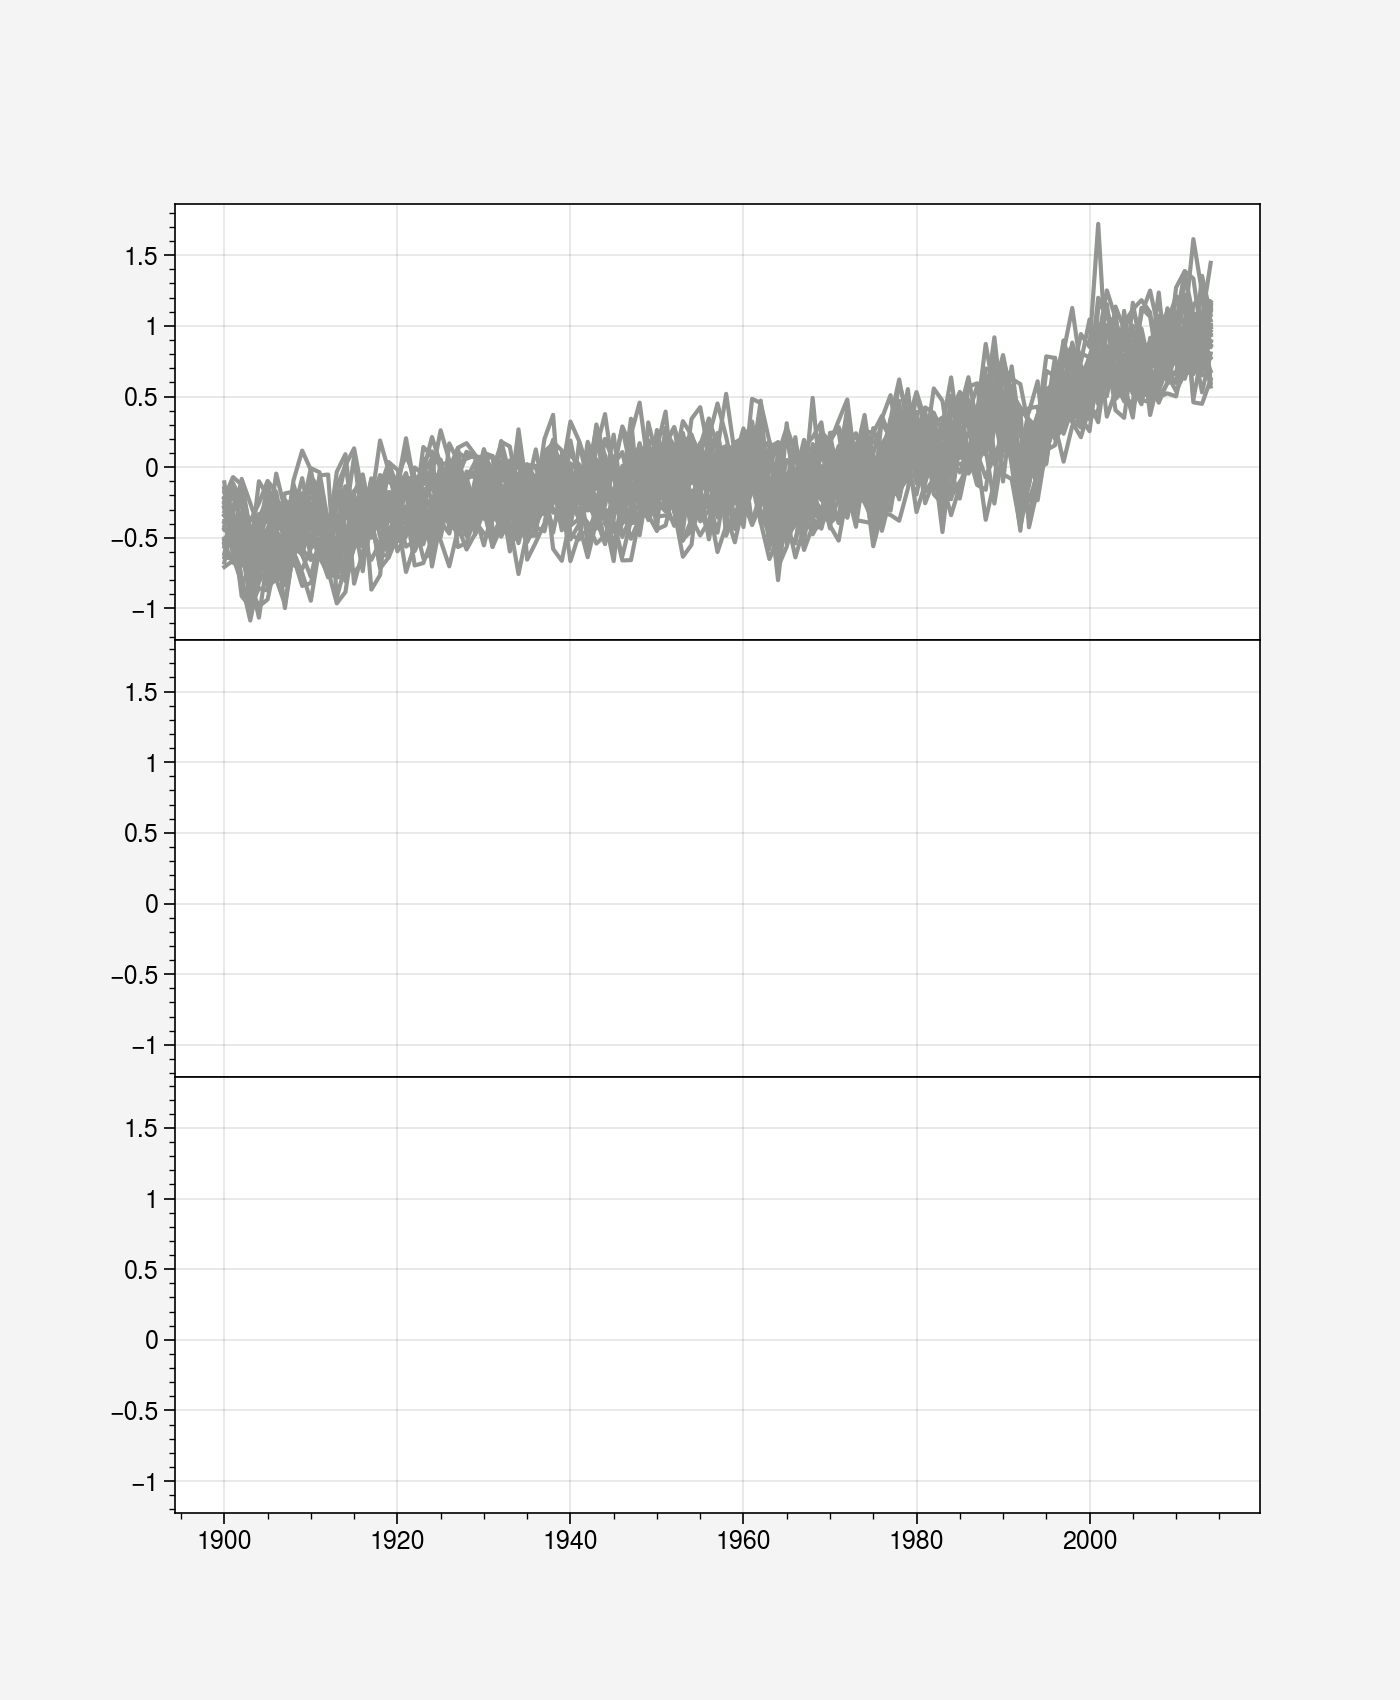

In [ ]:
fig,axs = plt.subplots(3,1, figsize=(7,8.5), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0)
for i in range(num_time_series):
    axs[0].plot(x, tas_ano_annual[i, :], color='gray')
    
axs[0].plot(x, CRUTEMP_annual, color='green', label='CRUTEMP')
axs[0].plot(x, GISSTEMP_annual, color='orange', label='GISSTEMP')
axs[0].plot(x, MLOSTTEMP_annual, color='blue', label='MLOST/Land')
axs[0].plot(x, tas_annual_mean, color='black', label='MPI-ESM-LR-esm')
axs[0].set_title('MPI-ESM1-LR 1900-2014 NH LSATAs',fontsize=14)
axs[0].set_ylabel('Annual (°C)', fontsize=14)
axs[0].set_xlabel('Time/year', fontsize=14)
# axs[0].grid(visible=False, which='major', axis='y')
axs[0].tick_params(axis='x', labelsize=10)
axs[0].tick_params(axis='y', labelsize=10)
axs[0].legend()
# Plot the JJA time series
for i in range(num_time_series):
    axs[1].plot(x, JJA_tas_mean[i, :], label=f"Time Series {i+1}", color='gray')

axs[1].plot(x, CRUTEMP_JJA, color='green')
axs[1].plot(x, GISSTEMP_JJA, color='orange')
axs[1].plot(x, MLOSTTEMP_JJA, color='blue')
axs[1].plot(x, tas_JJA_mean, color='black')
axs[1].set_ylabel('JJA (°C)', fontsize=14)
axs[1].set_xlabel('Time/year', fontsize=14)
# axs[1].grid(visible=False, which='major', axis='y')
axs[1].tick_params(axis='x', labelsize=10)
axs[1].tick_params(axis='y', labelsize=10)

# Plot the DJF time series
for i in range(num_time_series):
    axs[2].plot(x, DJF_tas_mean[i, :], label=f"Time Series {i+1}", color='gray')
    
axs[2].plot(x, CRUTEMP_DJF, color='green')
axs[2].plot(x, GISSTEMP_DJF, color='orange')
axs[2].plot(x, MLOSTTEMP_DJF, color='blue')
axs[2].plot(x, tas_DJF_mean, color='black')
# axs[2].set_title('MPI-ESM1-LR 1850-2014 DJF SAT')
axs[2].set_ylabel('DJF(°C)', fontsize=14)
axs[2].set_xlabel('Time/year', fontsize=14)
# axs[2].grid(visible=False, which='major', axis='y')
axs[2].tick_params(axis='x', labelsize=10)
axs[2].tick_params(axis='y', labelsize=10)

plt.show()

In [27]:
fig.savefig("/work/mh0033/m301036/josie/LSAT/output-Figures/MPI-ESM-LR-NH_SATAs_1900-2014.png",format='png')

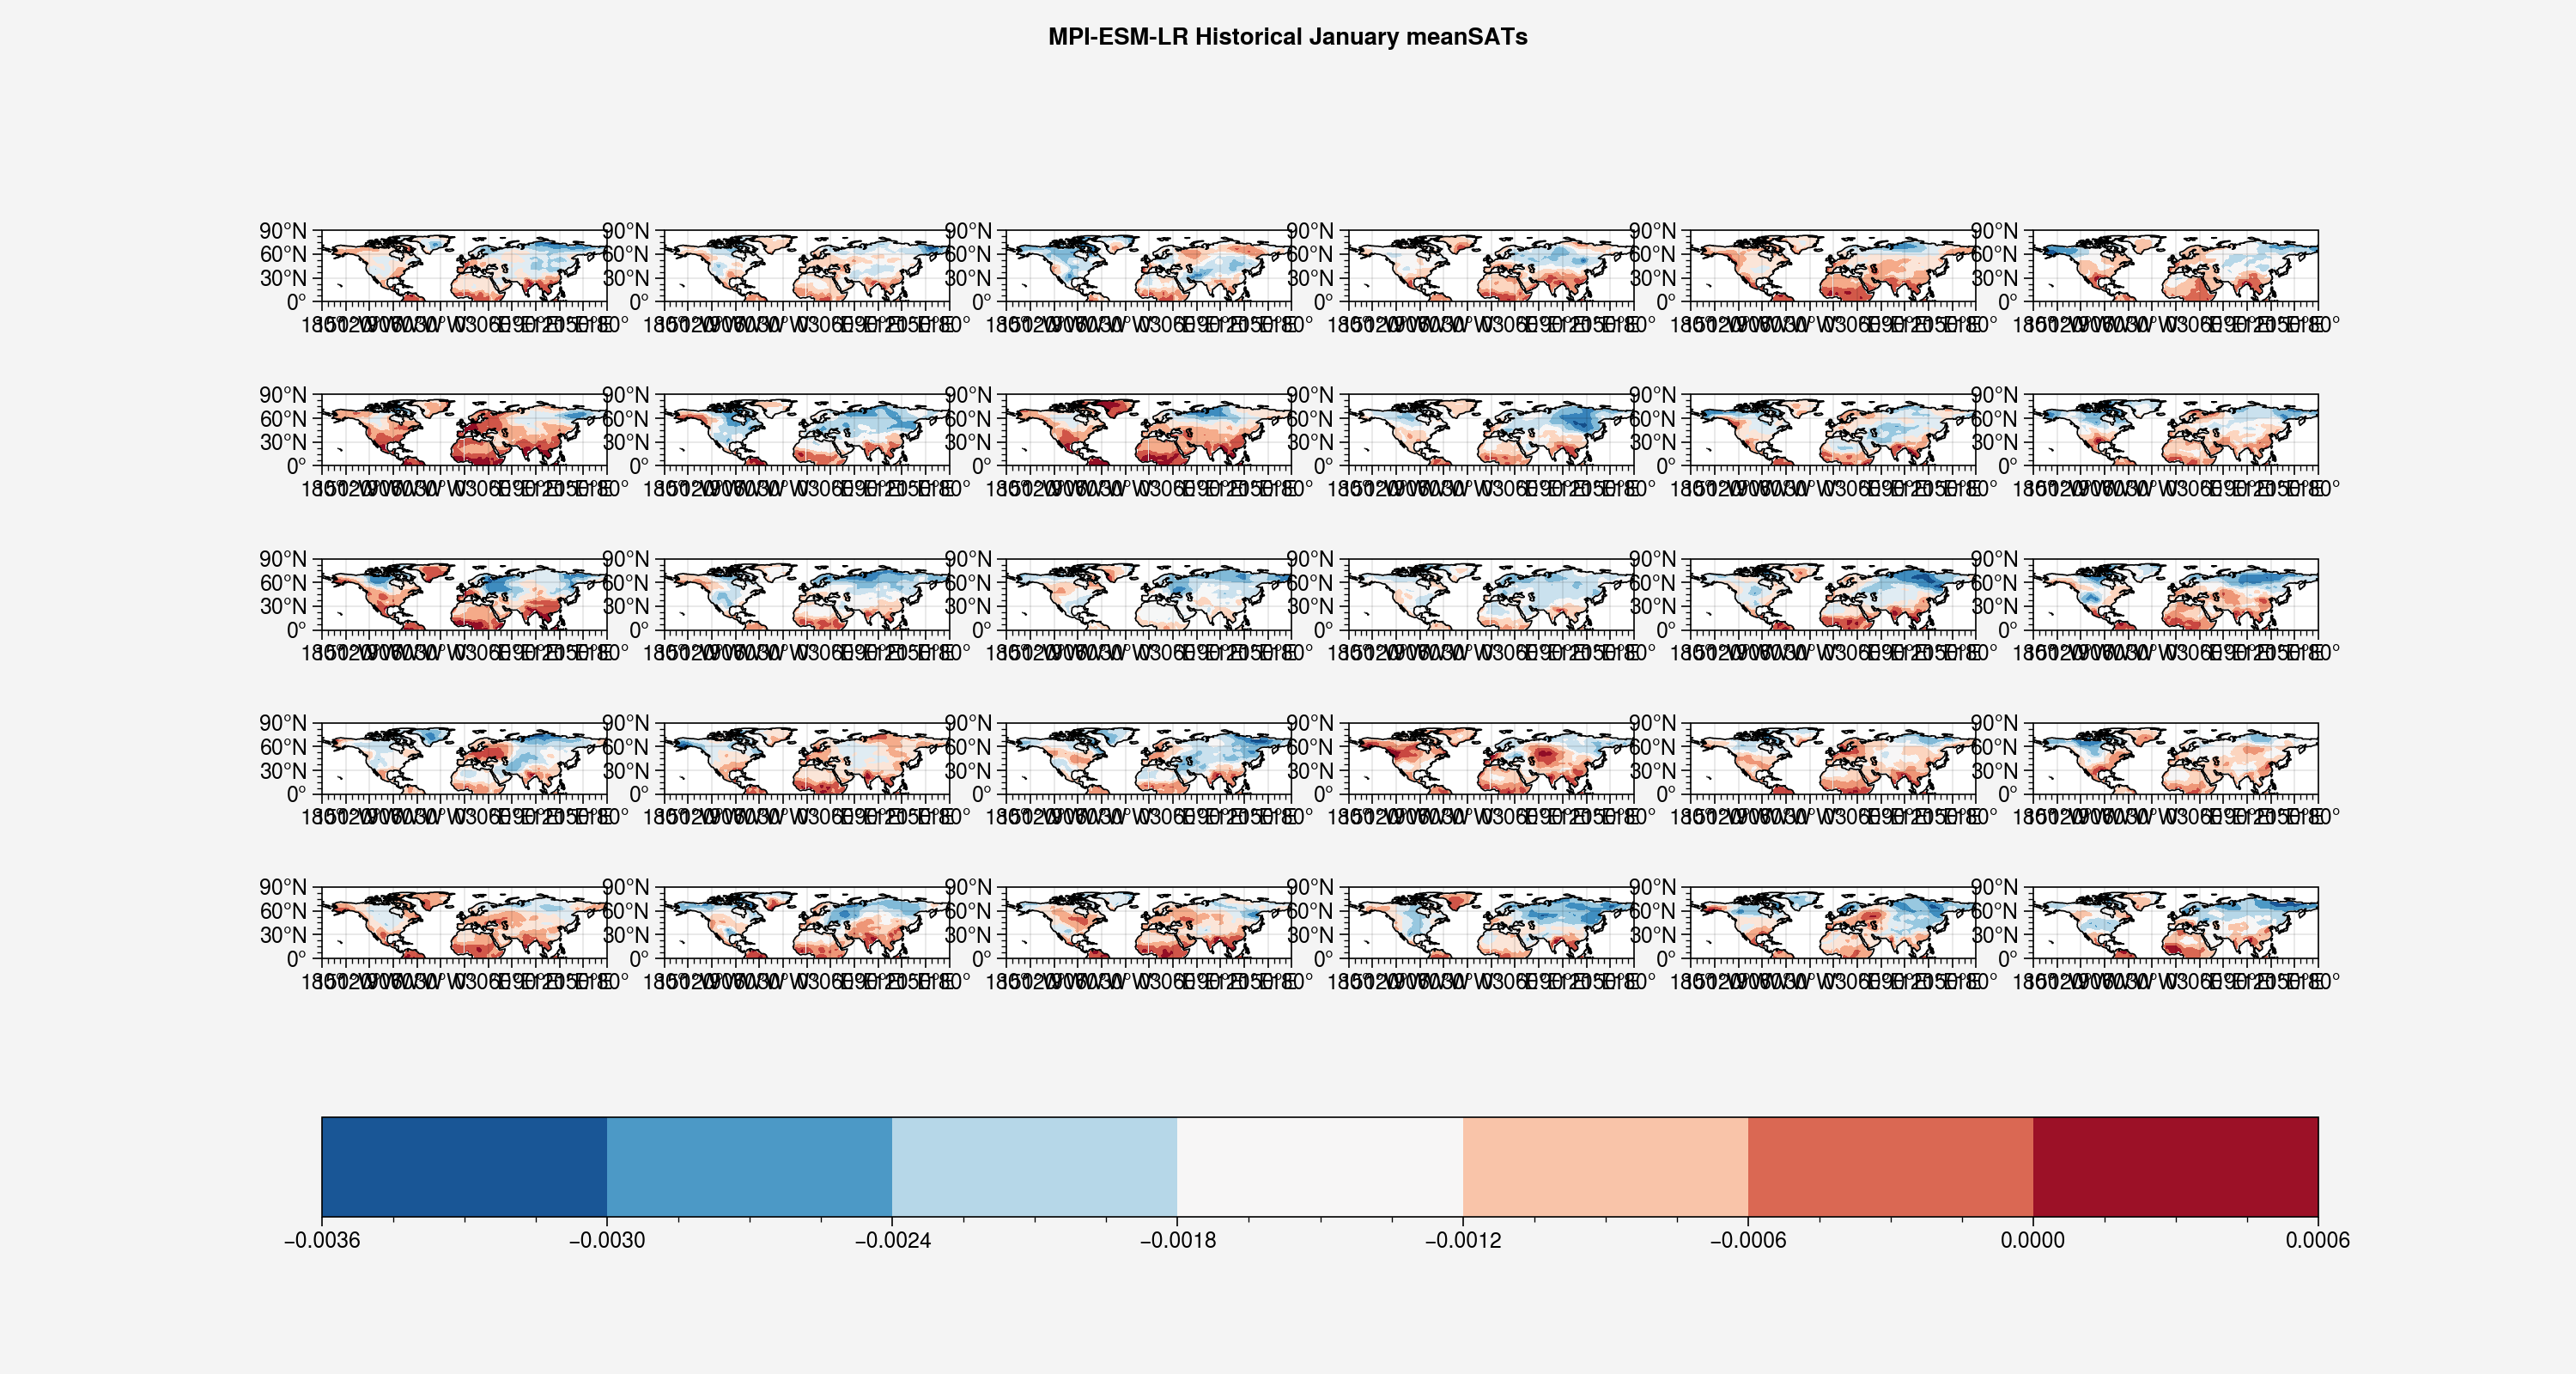

In [57]:

# import proplot as pplt
rows = 5
cols = 6

# create the figure and axes
projection = ccrs.PlateCarree()
fig, axs = plt.subplots(rows, cols, figsize=(15,8), subplot_kw={'projection':projection})
fig.suptitle('MPI-ESM-LR Historical January meanSATs')

# plot each model run
for i,ax in enumerate(axs.flat):
    mp=ax.contourf(lon, lat, annual_mean_anomalies[i, :, :], cmap='RdBu_r')#levels=np.arange(-30,30, 2.5)
    ax.set_xticks(np.arange(-180, 210, 30))#, crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(0, 120, 30))#, crs=ccrs.PlateCarree())
    ax.xaxis.set_major_formatter(cticker.LongitudeFormatter())
    ax.yaxis.set_major_formatter(cticker.LatitudeFormatter())
    ax.coastlines()
fig.colorbar(mp, ax=axs, orientation='horizontal', fraction=.1)
    
# add a legend and axis labels
# ax.legend()
# ax.set_xlabel('Time')
# ax.set_ylabel('Model Output')
# display the figure
plt.show()
# images = []
# for i in range(Nr):
#     for j in range(Nc):
#         # Generate data with a range that varies from one plot to the next.
#         data = tas_ano()
#         images.append(axs[i, j].imshow(data))
#         axs[i, j].label_outer()

# # Find the min and max of all colors for use in setting the color scale.
# vmin = min(image.get_array().min() for image in images)
# vmax = max(image.get_array().max() for image in images)
# norm = colors.Normalize(vmin=vmin, vmax=vmax)
# for im in images:
#     im.set_norm(norm)